# Camera models and Homographies

In this weeks lectures, we started to look at camera models. Lets explore these a bit more.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from math import cos, sin

Lets imagine I have a camera with the following intrinsic matrix:

$\mathbf{K} = \begin{bmatrix} 1200 & 0 & 340\\ 0 & 1200 & 240\\ 0 & 0 & 1 \end{bmatrix} $

### Activity 1

- What is the focal length of this camera?
- Can you work out what the field of view of the camera is?
- Can you guess what the image dimensions of this camera are?

### Projection
Lets imagine a set of points on a curve in 3D space. Assuming a camera is directly in front of the curve, how will this curve appear in our image?

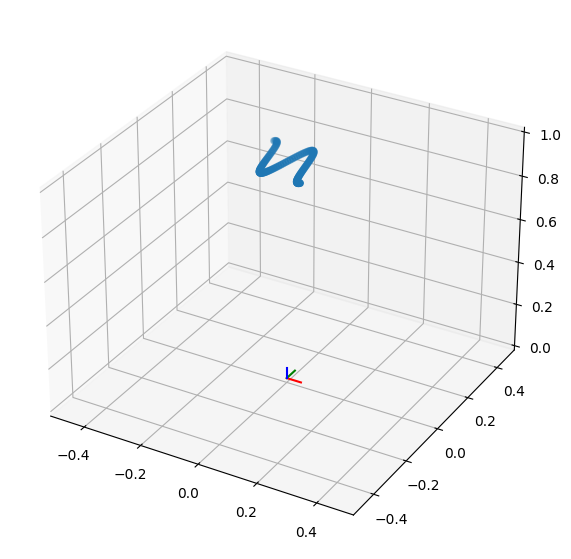

In [2]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

x = np.linspace(-0.1,0.1,100)
y = 0.1*np.sin(50*x)
z = np.ones(100)

ax.scatter3D(x,y,z)
ax.plot([0,0.05],[0,0],[0,0],'r')
ax.plot([0,0],[0,0.05],[0,0],'g')
ax.plot([0,0],[0,0],[0,0.05],'b')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
ax.set_zlim(0,1)
plt.show()

We now have 100 different coordinate vectors: (3, 100)


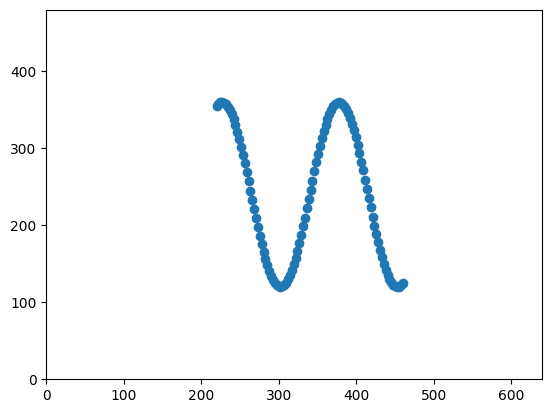

In [3]:
K = np.array([[1200,0,340],[0,1200,240],[0,0,1]])

# Create a coordinate vector for all points
X = np.vstack([x,y,z])

print("We now have 100 different coordinate vectors:",X.shape)

# Project into image plane
im_coords_scaled = K@X
im_coords = im_coords_scaled/im_coords_scaled[2,:]

plt.plot(im_coords[0,:],im_coords[1,:],'o')
plt.xlim(0,640)
plt.ylim(0,480)
plt.show()

What if our camera rotates or translates slightly? Lets consider the full case, where we first rotate and translate before projection.

$\mathbf{u} = \mathbf{K}\begin{bmatrix}\mathbf{R} & \mathbf{t}\end{bmatrix} \mathbf{X} $

In [4]:
K = np.array([[1200,0,340],[0,1200,240],[0,0,1]])


def get_transformation_matrix(roll,pitch,yaw,tx,ty,tz):
    return np.array(
            [[cos(yaw) * cos(pitch), -sin(yaw) * cos(roll) + cos(yaw) * sin(pitch) * sin(roll), sin(yaw) * sin(roll) + cos(yaw) * sin(pitch) * cos(roll), tx],
             [sin(yaw) * cos(pitch), cos(yaw) * cos(roll) + sin(yaw) * sin(pitch)
              * sin(roll), -cos(yaw) * sin(roll) + sin(yaw) * sin(pitch) * cos(roll), ty],
             [-sin(pitch), cos(pitch) * sin(roll), cos(pitch) * cos(yaw), tz]
             ])

# Rotate camera 45 degrees and pull it back 0.5 m
T = get_transformation_matrix(0,0,np.pi/4,0,0,0.5)

print("Transformation matrix: \n",T)
# Create a homogenous coordinate vector for all points
X = np.vstack([x,y,z,np.ones(100)])

print("We now have 100 different homogenous coordinate vectors:",X.shape)


# Project into image plane
im_coords_scaled = K@T@X
im_coords = im_coords_scaled/im_coords_scaled[2,:]

Transformation matrix: 
 [[ 0.70710678 -0.70710678  0.          0.        ]
 [ 0.70710678  0.70710678  0.          0.        ]
 [-0.          0.          0.70710678  0.5       ]]
We now have 100 different homogenous coordinate vectors: (4, 100)


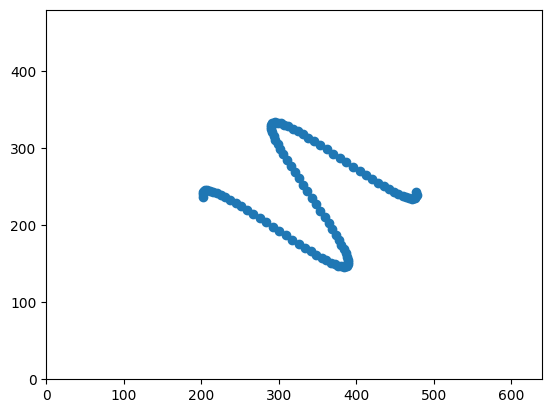

In [5]:
plt.plot(im_coords[0,:],im_coords[1,:],'o')
plt.xlim(0,640)
plt.ylim(0,480)
plt.show()

### Activity 2

Modify the code above to try out different rotation and translations. 

- How does this affect the camera projection.
- What is translating and rotating, the camera or the points?

Ok, why is this important? Well, if we can detect points in an image, and know something about the object dimensions or structure, we can say something about it's position and orientation. This is valuable for a range of applications, eg. a robot grasping an object. We'll also use this knowledge later on, to build 3D models of objects from multiple views.

As another example, assuming you know the camera intrinsics, and that a golf ball is 42 mm in diameter, and you can find find the diameter of an ball in an image, you can estimate how far away the ball is from a camera. 

### Try this at home: 
So how do we find our camera intrinsics?
- [Calibrate](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) your webcam to find the matrix $\mathbf{K}$  

## Homographies 

Before we jump into multi-view geometry and 3D geometry, lets think about planar geometry and operations. We already encountered these operations last week, when we warped images using shear, affine and rotational transformations. This week we'll look at the reverse approach, lets look at how to recover a homography, from corresponding point matches. We'll use an ORB descriptor built into opencv, which improves on the brief descriptor we used last week.

In [6]:
im_1 = cv2.cvtColor(cv2.resize(cv2.imread('../test_images/Drone_1.jpg'),(400,400)), cv2.COLOR_BGR2GRAY)
im_2 = cv2.cvtColor(cv2.resize(cv2.imread('../test_images/Drone_2.jpg'),(400,400)), cv2.COLOR_BGR2GRAY)

In [7]:
# Initiate ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(im_1,None)
kp2, des2 = orb.detectAndCompute(im_2,None)

In [8]:
# Match keypoints
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

In [9]:
# Sort matches
matches = sorted(matches, key = lambda x:x.distance)

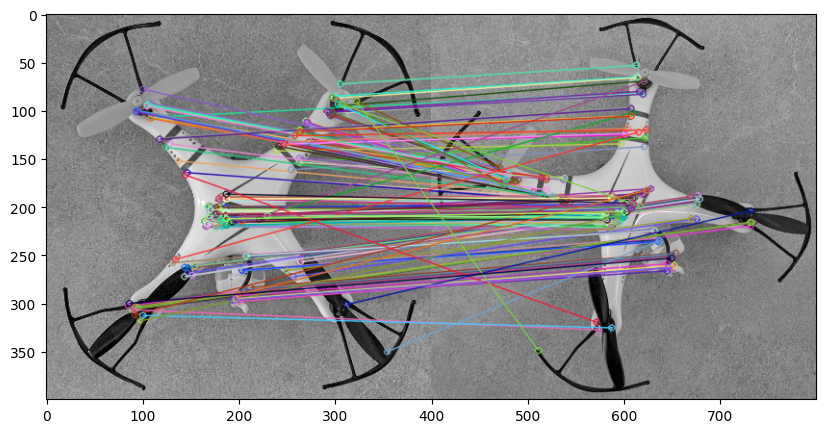

In [10]:
# Draw first 20 matches.
plt.figure(figsize=(15,5))
img3 = cv2.drawMatches(im_1,kp1,im_2,kp2,matches[:],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [11]:
# Find keypoint correspondences
X1 = np.vstack([kp1[match.queryIdx].pt for match in matches])
X2 = np.vstack([kp2[match.trainIdx].pt for match in matches])

# Estimate homograpahy using opencv - 
#Hcv, mask = cv2.findHomography(X2, X1, cv2.RANSAC, 5.0)

Ok, we have two N x 2 of corresponding keypoints. We're now ready to compute the homography between these.
In opencv this is easy 

Hcv, mask = cv2.findHomography(X2, X1, cv2.RANSAC, 5.0) 

but we'll write our own code to understand this better.

In [12]:
# Create a matrix from 1 keypoint correspondence
def point_correspondance_matrix(x,y,u,v):
    
    row_1 = np.array([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
    row_2 = np.array([0, 0, 0, -x, -y, -1, x*v, y*v, v])

    return (np.vstack([row_1,row_2]))
    
# Create a full matrix from multiple keypoint correspondences - technically this works with more than 4 points too
def four_point_correspondance_matrix(kp1,kp2):
    
    rows = []
    for i in range(kp1.shape[0]):
        rows.append(point_correspondance_matrix(kp1[i,0],kp1[i,1],kp2[i,0],kp2[i,1]))
    return np.vstack(rows)

In [13]:
# Find the homography using singular value decomposition
def find_homography(kp1,kp2):
    
    M = four_point_correspondance_matrix(kp1,kp2)
    
    U,S,Vt  = np.linalg.svd(M)
    H = Vt[-1,:].reshape(3,3) #Null space corresponds to smallest singular value
    return H/H[2,2] # Typically normalise by the last element of the homography 

In [14]:
# Find a homography using ransac
def ransac_homography(kp1,kp2,N=1000,max_error=5.0):
    
    best_consensus_size = 0
    best_H = np.eye(3)
    
    for j in range(N):
        
        # Pick 4 points at random
        bins = np.random.choice(kp1.shape[0],4,replace=False)
        
        # Calculate Homography
        H = find_homography(kp1[bins,:],kp2[bins,:])
        
        # Project points using Homography
        X1_h = np.hstack((kp1,np.ones((kp1.shape[0],1)))).T # homogenous coordinates
        
        projected = H@X1_h
        # Normalise (last column must be one for homogenous coordinates) 
        X1_2 = projected[0:2,:]/projected[2,:] 
        
        # Calculate reprojection error
        reprojection_errors = np.sqrt(np.sum(np.power(X2-X1_2.T,2),axis=1))
        
        # Count consensus set size
        consensus_size = np.sum(reprojection_errors<max_error)
        
        # Save current best homography
        if consensus_size > best_consensus_size:
            best_consensus_size = consensus_size
            best_H = H
            
    return best_H

In [15]:
H = ransac_homography(X1,X2,N=10000,max_error=5)
print(H)

[[ 7.05252665e-01  4.19678742e-01 -3.34761490e+01]
 [-4.87374763e-01  6.08428822e-01  1.57780822e+02]
 [ 7.55921155e-05 -2.99869587e-04  1.00000000e+00]]


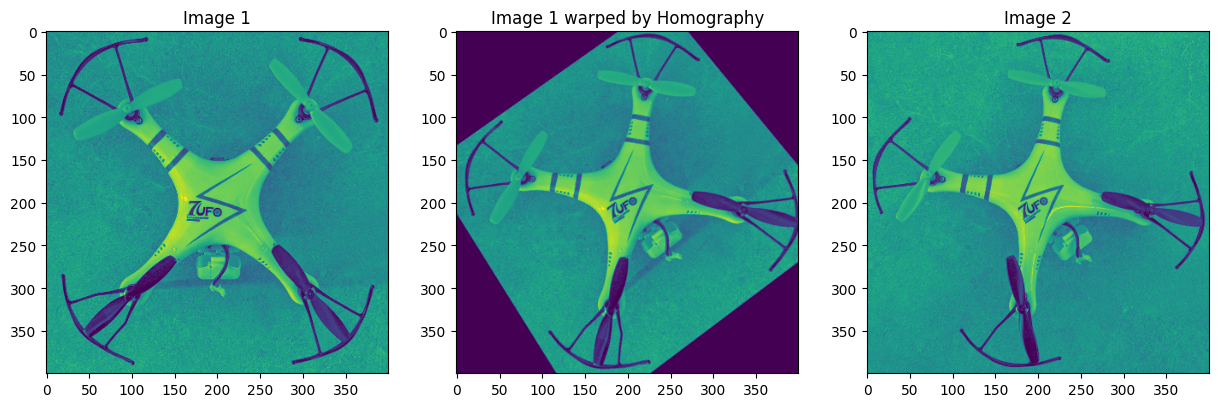

In [16]:
# Lets apply the homography to our image - in theory it should generate the second picture 
im_warp = cv2.warpPerspective(im_1,H,(im_1.shape[0],im_1.shape[1]))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im_1)
plt.title('Image 1')
plt.subplot(1,3,2)
plt.imshow(im_warp)
plt.title('Image 1 warped by Homography')
plt.subplot(1,3,3)
plt.imshow(im_2)
plt.title('Image 2')
plt.show()

Cool, that warped our first image to make it look like our second image! Think the warp-perspective function is magic? Don't worry, in one of the labs you'll write the code to implement this. :-)

### Activity 3 

Increase the maximum error used to find the consensus set. 

- What happens as more points are used and outliers start to corrupt the homography?
- Modify the code above to map image 2 onto image 1 instead, without recomputing the homography.
- List at least three applications of homographies.

